###### [출처]https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/beginner/transfer_learning_tutorial.html

- 전이학습

전이학습(transfer learning)은 사전에 학습된 모델을 이용하여 새로운 

In [9]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [10]:
# 데이터 불러오기 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

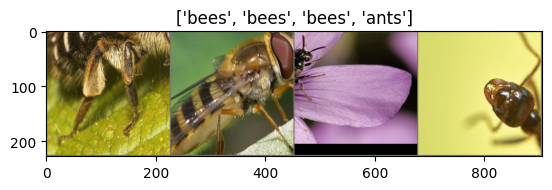

In [29]:
# 일부 이미지 시각화
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01) # .pause를 통해 loop내에서 종료될 수 있게 함


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # validation으로 적용

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # .zero_grad()를 통한 gradient 초기화
                optimizer.zero_grad() 

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #deepcopy를 통해 내부 객체까지 모두 복사
        print()

# 학습 상황 시각화
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
# 모델 예측값 시각화

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [22]:
# Finetuning
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\islab\.conda\envs\mings\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\islab\.conda\envs\mings\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


c:\Users\islab\.conda\envs\mings\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5124 Acc: 0.7500
val Loss: 0.1832 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4271 Acc: 0.8402
val Loss: 0.1956 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4961 Acc: 0.8074
val Loss: 0.2864 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4635 Acc: 0.8320
val Loss: 0.2130 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5226 Acc: 0.7951
val Loss: 0.2492 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5413 Acc: 0.8033
val Loss: 0.3175 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.4773 Acc: 0.7623
val Loss: 0.2183 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3731 Acc: 0.8361
val Loss: 0.1929 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3582 Acc: 0.8320
val Loss: 0.1995 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2946 Acc: 0.8689
val Loss: 0.1772 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2698 Acc: 0.9016
val Loss: 0.1806 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2826 Acc: 0.8934
val Loss: 0.1697 Acc: 0.9346

Epoch 12/24
----------
t

In [24]:
# Freezing
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5970 Acc: 0.6885
val Loss: 0.2833 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4305 Acc: 0.8115
val Loss: 0.1945 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3912 Acc: 0.8074
val Loss: 0.1778 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.3033 Acc: 0.8484
val Loss: 0.2752 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4375 Acc: 0.7787
val Loss: 0.3950 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.4761 Acc: 0.8238
val Loss: 0.1840 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3426 Acc: 0.8279
val Loss: 0.2010 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4307 Acc: 0.8074
val Loss: 0.2476 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3474 Acc: 0.8238
val Loss: 0.1900 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3784 Acc: 0.8361
val Loss: 0.1891 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4511 Acc: 0.7951
val Loss: 0.1943 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3740 Acc: 0.8320
val Loss: 0.1830 Acc: 0.9477

Ep

KeyboardInterrupt: 